In [1]:
# Primero, en la primera celda del notebook puedes instalar las bibliotecas necesarias (si aún no están instaladas):

!pip install pyspark kafka-python pandas matplotlib

In [1]:
import os
import csv
import random
import datetime

# Lista de posibles tipos de eventos con una distribución realista
event_types = [
    ('INFO', 0.6),  # 60% de logs informativos
    ('WARNING', 0.15),  # 15% de advertencias
    ('ERROR', 0.1),  # 10% de errores
    ('DEBUG', 0.1),  # 10% de depuración
    ('LOGIN_FAILURE', 0.05)  # 5% de intentos de acceso fallidos
]

# Lista de posibles usuarios y direcciones IPs
users = ['admin', 'user1', 'user2', 'guest', 'root', 'test']
ips = [
    '192.168.1.10', '192.168.1.15', '10.0.0.1', '172.16.0.2',
    '203.0.113.45', '8.8.8.8', '185.199.108.153'
]

# Función para elegir un tipo de evento basado en la distribución de probabilidad
def choose_event_type():
    return random.choices([e[0] for e in event_types], weights=[e[1] for e in event_types])[0]

# Función para generar un log aleatorio
def generate_log():
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    event_type = choose_event_type()
    user = random.choice(users)
    ip = random.choice(ips)
    
    if event_type == 'LOGIN_FAILURE':
        message = f"Intento de acceso fallido para usuario {user} desde {ip}"
    elif event_type == 'ERROR':
        message = f"Error crítico en el sistema detectado por el usuario {user}"
    elif event_type == 'WARNING':
        message = f"Posible anomalía detectada desde la IP {ip}"
    elif event_type == 'DEBUG':
        message = f"Modo depuración activo por usuario {user}"
    else:  # INFO
        message = f"Evento normal registrado para usuario {user} desde {ip}"
    
    return [timestamp, event_type, user, ip, message]

# Función para generar múltiples logs y guardarlos en un archivo CSV
def generate_logs(file_path="logs/log.csv", num_logs=200):
    folder = os.path.dirname(file_path)
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['timestamp', 'event_type', 'user', 'ip', 'message'])
        
        for _ in range(num_logs):
            writer.writerow(generate_log())

# Ejecutar la generación de logs
generate_logs("logs/log.csv")


In [2]:
# La siguiente celda es para configurar la sesión de Spark y verificar que todo esté listo:

from pyspark.sql import SparkSession

# Crea una sesión de Spark
spark = SparkSession.builder \
    .appName("SIEM with Spark in Jupyter") \
    .getOrCreate()

# Verifica que Spark está funcionando correctamente
print(spark.version)


3.5.4


In [3]:
def read_logs_from_csv(file_path="logs/log.csv"):
    # Leemos los logs desde el archivo CSV
    df = spark.read.option("header", "true").csv(file_path)
    
    # Mostramos los primeros 5 logs como ejemplo
    df.show(5)

    return df

# Llamamos a la función para leer los logs
logs_df = read_logs_from_csv("logs/log.csv")


+-------------------+----------+-----+---------------+--------------------+
|          timestamp|event_type| user|             ip|             message|
+-------------------+----------+-----+---------------+--------------------+
|2025-03-31 19:43:41|     ERROR|admin|     172.16.0.2|Error cr�tico en ...|
|2025-03-31 19:43:41|      INFO| root|185.199.108.153|Evento normal reg...|
|2025-03-31 19:43:41|     DEBUG| root|   203.0.113.45|Modo depuraci�n a...|
|2025-03-31 19:43:41|   WARNING|admin|     172.16.0.2|Posible anomal�a ...|
|2025-03-31 19:43:41|      INFO|user2|   203.0.113.45|Evento normal reg...|
+-------------------+----------+-----+---------------+--------------------+
only showing top 5 rows



In [4]:
from pyspark.sql.functions import col, regexp_extract

# Filtra solo eventos de login fallido
login_failures = logs_df.filter(logs_df.event_type == "LOGIN_FAILURE")

# Muestra los eventos filtrados
login_failures.show()


+-------------------+-------------+-----+---------------+--------------------+
|          timestamp|   event_type| user|             ip|             message|
+-------------------+-------------+-----+---------------+--------------------+
|2025-03-31 19:43:41|LOGIN_FAILURE| test|   192.168.1.10|Intento de acceso...|
|2025-03-31 19:43:41|LOGIN_FAILURE| test|        8.8.8.8|Intento de acceso...|
|2025-03-31 19:43:41|LOGIN_FAILURE|admin|185.199.108.153|Intento de acceso...|
|2025-03-31 19:43:41|LOGIN_FAILURE| test|   192.168.1.10|Intento de acceso...|
|2025-03-31 19:43:41|LOGIN_FAILURE| root|     172.16.0.2|Intento de acceso...|
|2025-03-31 19:43:41|LOGIN_FAILURE|user1|     172.16.0.2|Intento de acceso...|
|2025-03-31 19:43:41|LOGIN_FAILURE|admin|185.199.108.153|Intento de acceso...|
|2025-03-31 19:43:41|LOGIN_FAILURE|guest|   192.168.1.10|Intento de acceso...|
|2025-03-31 19:43:41|LOGIN_FAILURE|user2|   192.168.1.10|Intento de acceso...|
+-------------------+-------------+-----+-----------

In [5]:
# En esta celda puedes generar alertas basadas en el análisis de logs. Por ejemplo, si hay un número excesivo de intentos de login fallido en un período de tiempo:

# Alerta si hay un número excesivo de intentos de login fallidos
from pyspark.sql.functions import window

alert_df = login_failures.groupBy(window("timestamp", "5 minutes")).count()

alert_df.show()


+--------------------+-----+
|              window|count|
+--------------------+-----+
|{2025-03-31 19:40...|    9|
+--------------------+-----+



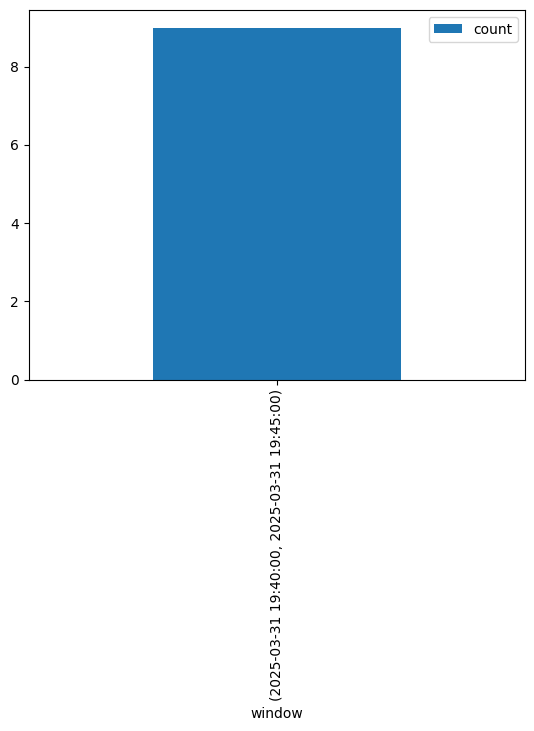

In [7]:
# Aquí puedes visualizar los resultados utilizando bibliotecas como Matplotlib o Seaborn:

import matplotlib.pyplot as plt

# Supón que tienes un DataFrame de Pandas con resultados
alert_data = alert_df.toPandas()
alert_data.plot(kind='bar', x='window', y='count')
plt.show()


In [24]:
# Finalmente, puedes guardar los resultados procesados en un archivo de texto, CSV, o cualquier formato que necesites:

alert_data.to_csv("results/results.txt", index=False, header=False)
